In [4]:
import requests
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [5]:
# Acquire data from Disney API

base_url = "https://api.disneyapi.dev/character"

def fetch_characters(page=1):
    response = requests.get(f"{base_url}?page={page}")
    return response.json()

# Initialize an empty list to store all characters
all_characters = []

# Get data from all pages (getting from 150 pages)
for page in range(1, 150):  
    print(f"Fetching page {page}...")
    data = fetch_characters(page)
    all_characters.extend(data['data'])

# Convert to DataFrame
characters_df = pd.DataFrame(all_characters)

# Show the first few rows
characters_df.head()

Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...
Fetching page 21...
Fetching page 22...
Fetching page 23...
Fetching page 24...
Fetching page 25...
Fetching page 26...
Fetching page 27...
Fetching page 28...
Fetching page 29...
Fetching page 30...
Fetching page 31...
Fetching page 32...
Fetching page 33...
Fetching page 34...
Fetching page 35...
Fetching page 36...
Fetching page 37...
Fetching page 38...
Fetching page 39...
Fetching page 40...
Fetching page 41...
Fetching page 42...
Fetching page 43...
Fetching page 44...
Fetching page 45...
Fetching page 46...
Fetching page 47...
Fetching page 48...
Fetching page 49...
Fetching page 50...
Fetching 

,_id,films,shortFilms,tvShows,videoGames,parkAttractions,allies,enemies,sourceUrl,name,imageUrl,createdAt,updatedAt,url,__v,alignment
0,112,[Hercules (film)],[],[Hercules (TV series)],[Kingdom Hearts III],[],[],[],https://disney.fandom.com/wiki/Achilles_(Hercu...,Achilles,https://static.wikia.nocookie.net/disney/image...,2021-04-12T01:31:30.547Z,2021-12-20T20:39:18.033Z,https://api.disneyapi.dev/characters/112,0,NaN
1,18,"[The Fox and the Hound, The Fox and the Hound 2]",[],[],[],[],[],[],https://disney.fandom.com/wiki/Abigail_the_Cow,Abigail the Cow,https://static.wikia.nocookie.net/disney/image...,2021-04-12T01:26:03.413Z,2021-12-20T20:39:18.032Z,https://api.disneyapi.dev/characters/18,0,NaN
2,16,[Cheetah],[],[],[],[],[],[],https://disney.fandom.com/wiki/Abdullah,Abdullah,https://static.wikia.nocookie.net/disney/image...,2021-04-12T01:26:02.377Z,2021-12-20T20:39:18.032Z,https://api.disneyapi.dev/characters/16,0,NaN
3,45,"[Mary Poppins (film), Mary Poppins Returns]",[],[],[],[],[],[],https://disney.fandom.com/wiki/Admiral_Boom_an...,Admiral Boom and Mr. Binnacle,https://static.wikia.nocookie.net/disney/image...,2021-04-12T01:26:21.560Z,2021-12-20T20:39:18.033Z,https://api.disneyapi.dev/characters/45,0,NaN
4,7,[],[],[Gravity Falls],[],[],[],[],https://disney.fandom.com/wiki/.GIFfany,.GIFfany,https://static.wikia.nocookie.net/disney/image...,2021-04-12T01:25:10.354Z,2021-12-20T20:39:18.032Z,https://api.disneyapi.dev/characters/7,0,NaN


In [6]:
# Only want the 'name', '_id' and 'films' columns.

# Filter out rows where the 'films' column is missing or empty
filtered_characters_df = characters_df[characters_df['films'].notna() & characters_df['films'].apply(len) > 0]

# Select only the columns _id, films, and name
filtered_characters_df = filtered_characters_df[['name', '_id', 'films']]

# Display the resulting DataFrame
#filtered_df.head()

filtered_characters_df

,name,_id,films
0,Achilles,112,[Hercules (film)]
2,Abdullah,16,[Cheetah]
11,Amos,215,[Ben and Me]
17,Ashcan and Pete,337,[Homeward Bound II: Lost in San Francisco]
18,Aspen,342,[Bedtime Stories]
...,...,...,...
7422,Jenny Wren,7382,[Who Framed Roger Rabbit]
7425,"Yao, Ling, and Chien Po",7420,"[Mulan, Mulan II, Mulan (2020 film)]"
7426,Stanley Yelnats III,7429,[Holes]
7427,Yin,7436,[Leroy & Stitch]


In [7]:
# Need to clean data for 'films' column (removing [], () and :)

# Function to clean text data
def clean_text(text):
    # Remove square brackets, parentheses, colons, and other unwanted characters
    text = re.sub(r'[\[\]\(\):,]', '', text)   # Removes brackets, parentheses, and colons
    text = re.sub(r'\s+', ' ', text)           # Replace multiple spaces with a single space
    text = text.lower()                        # Convert to lowercase
    return text

In [8]:
# Further cleaning of 'films' column

# Clean the 'films' column (convert lists to strings and clean the text)
filtered_characters_df['films_text'] = filtered_characters_df['films'].apply(lambda x: ' '.join(x))
filtered_characters_df['cleaned_films_text'] = filtered_characters_df['films_text'].apply(clean_text)

# Show the cleaned text for verification
print("Cleaned films text:")
print(filtered_characters_df[['name', 'cleaned_films_text']].head())

filtered_characters_df

Cleaned films text:
               name                       cleaned_films_text
0          Achilles                            hercules film
2          Abdullah                                  cheetah
11             Amos                               ben and me
17  Ashcan and Pete  homeward bound ii lost in san francisco
18            Aspen                          bedtime stories


,name,_id,films,films_text,cleaned_films_text
0,Achilles,112,[Hercules (film)],Hercules (film),hercules film
2,Abdullah,16,[Cheetah],Cheetah,cheetah
11,Amos,215,[Ben and Me],Ben and Me,ben and me
17,Ashcan and Pete,337,[Homeward Bound II: Lost in San Francisco],Homeward Bound II: Lost in San Francisco,homeward bound ii lost in san francisco
18,Aspen,342,[Bedtime Stories],Bedtime Stories,bedtime stories
...,...,...,...,...,...
7422,Jenny Wren,7382,[Who Framed Roger Rabbit],Who Framed Roger Rabbit,who framed roger rabbit
7425,"Yao, Ling, and Chien Po",7420,"[Mulan, Mulan II, Mulan (2020 film)]",Mulan Mulan II Mulan (2020 film),mulan mulan ii mulan 2020 film
7426,Stanley Yelnats III,7429,[Holes],Holes,holes
7427,Yin,7436,[Leroy & Stitch],Leroy & Stitch,leroy & stitch


In [9]:
# Update dataframe, removing the 'films' and 'films_text' columns

# Remove the 'films' and 'films_text' columns
filtered_characters_df = filtered_characters_df.drop(columns=['films', 'films_text'])

# Display the updated DataFrame
#print(filtered_characters_df.head())
filtered_characters_df

,name,_id,cleaned_films_text
0,Achilles,112,hercules film
2,Abdullah,16,cheetah
11,Amos,215,ben and me
17,Ashcan and Pete,337,homeward bound ii lost in san francisco
18,Aspen,342,bedtime stories
...,...,...,...
7422,Jenny Wren,7382,who framed roger rabbit
7425,"Yao, Ling, and Chien Po",7420,mulan mulan ii mulan 2020 film
7426,Stanley Yelnats III,7429,holes
7427,Yin,7436,leroy & stitch


In [10]:
# Apply TfidfVectorizer to X, to 'cleaned_films_text' column

# Vectorize the cleaned text using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(filtered_characters_df['cleaned_films_text'])

print(X.shape)

(2651, 703)


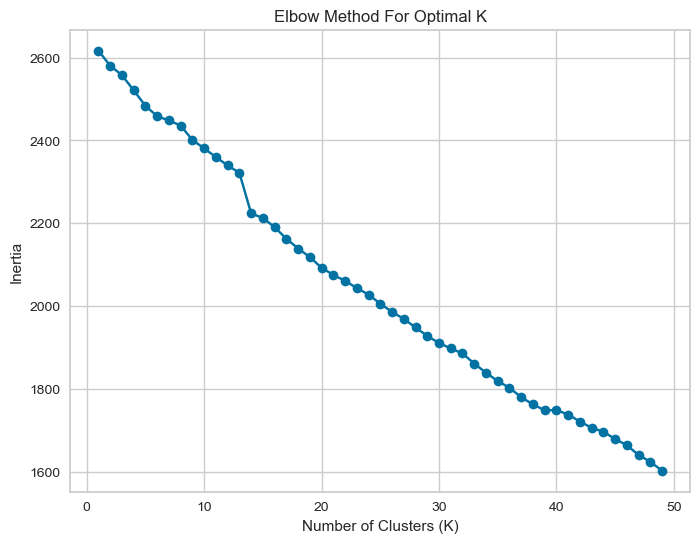

In [11]:
# Elbow Plot

from yellowbrick.cluster import KElbowVisualizer

# Elbow Method - Calculate Inertia for different values of K
inertia = []
K_range = range(1, 50)  # Trying K from 1 to 50 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig('ElbowMethod.png', dpi=300, bbox_inches='tight')
plt.show()

# Noticed an "elbow at K = 39", will take K = 39.

In [12]:
# Using K-Means Clustering and set number of clusters

# Chosen K = 39

# Apply KMeans clustering to the vectorized text
n_clusters = 39  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

filtered_characters_df['cluster'] = kmeans.labels_

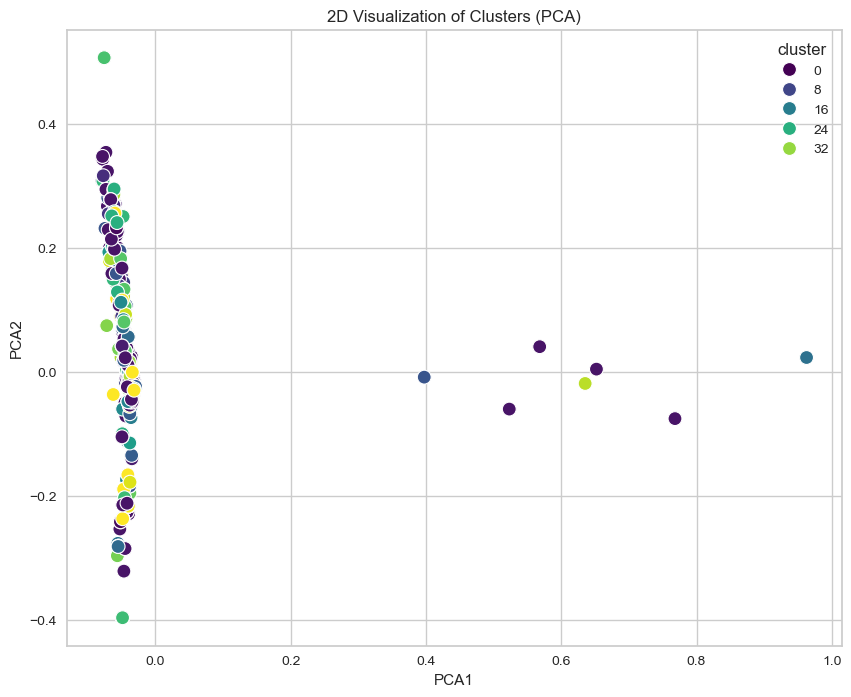

In [13]:
# PCA and plotting clusters

# Reduce dimensionality to 2D 
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# Create a DataFrame with the reduced data and cluster labels
pca_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = filtered_characters_df['cluster']

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=pca_df, palette='viridis', s=100)
plt.title("2D Visualization of Clusters (PCA)")
plt.savefig('2DVisualization.png', dpi=300, bbox_inches='tight')
plt.show()

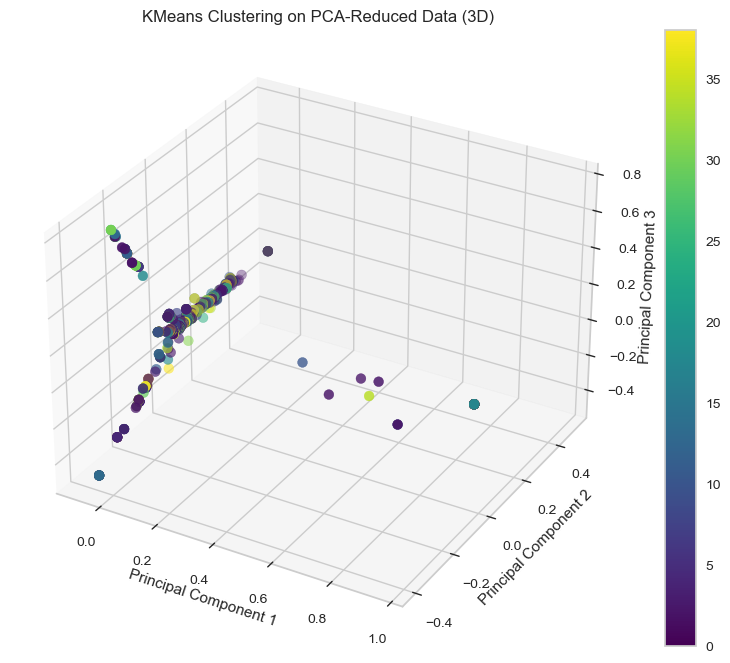

In [14]:
# 3D KMeans Clustering Plot

from mpl_toolkits.mplot3d import Axes3D

# Reduce dimensionality to 3D
pca_3d = PCA(n_components=3)
reduced_data_3d = pca_3d.fit_transform(X.toarray())

# Create a DataFrame with the 3D reduced data and cluster labels
pca_3d_df = pd.DataFrame(reduced_data_3d, columns=['PCA1', 'PCA2', 'PCA3'])
pca_3d_df['cluster'] = filtered_characters_df['cluster']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
scatter = ax.scatter(pca_3d_df['PCA1'], pca_3d_df['PCA2'], pca_3d_df['PCA3'],
                     c=pca_3d_df['cluster'], cmap='viridis', s=50)


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.colorbar(scatter)
plt.title("KMeans Clustering on PCA-Reduced Data (3D)")
plt.savefig('3DVisualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# See which Disney character is in which cluster

# Show the characters in each cluster
for i in range(n_clusters):
    print(f"\nCharacters in Cluster {i}:")
    cluster_characters = filtered_characters_df[filtered_characters_df['cluster'] == i]
    print(cluster_characters[['name', 'cleaned_films_text']].head())


Characters in Cluster 0:
                 name                                 cleaned_films_text
174      George Banks  mary poppins film saving mr. banks mary poppin...
191      Uncle Albert                                  mary poppins film
198             Angus                               mary poppins returns
454  The Balloon Lady                               mary poppins returns
456    Winifred Banks  mary poppins film mary poppins returns saving ...

Characters in Cluster 1:
                      name      cleaned_films_text
821       Captain Moreland   swiss family robinson
895     Sunset Boulevardez  the proud family movie
926  LaCienega Boulevardez  the proud family movie
950      Felix Boulevardez  the proud family movie
979       Papi Boulevardez  the proud family movie

Characters in Cluster 2:
              name        cleaned_films_text
2         Abdullah                   cheetah
11            Amos                ben and me
18           Aspen           bedtime storie

In [16]:
# See the top 10 words in each cluster

# Get feature names for each cluster centroid
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Display the top 10 words for each cluster
for i in range(n_clusters):
    print(f"Cluster {i}:")
    print("Top words:", [terms[ind] for ind in order_centroids[i, :10]])
    print("\n")

Cluster 0:
Top words: ['mary', 'poppins', 'returns', 'film', 'banks', 'saving', 'mr', 'frog', 'game', 'gadget']


Cluster 1:
Top words: ['family', 'proud', 'robinson', 'movie', 'swiss', 'hills', 'beverly', 'zorro', 'game', 'gadget']


Cluster 2:
Top words: ['jungle', 'frankenweenie', 'meet', 'robinsons', 'holes', 'woods', 'wild', 'pollyanna', 'force', 'book']


Cluster 3:
Top words: ['mickey', 'house', 'mouse', 'villains', 'christmas', 'snowed', 'magical', 'detective', 'great', 'film']


Cluster 4:
Top words: ['fantasia', '2000', 'halloween', 'bald', 'night', 'mountain', 'rescuers', 'house', 'mickey', 'film']


Cluster 5:
Top words: ['stitch', 'leroy', 'lilo', 'movie', 'glitch', 'internet', 'breaks', 'ralph', 'action', 'live']


Cluster 6:
Top words: ['dalmatians', '102', '101', '1996', 'patch', 'london', 'adventure', 'film', 'ii', 'house']


Cluster 7:
Top words: ['santa', 'clause', 'paws', 'search', 'buddies', 'escape', 'pups', 'zorro', 'friday', 'game']


Cluster 8:
Top words: ['car